# Network_analyser

## Imports

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

## Network reader

### Read to pandas

In [3]:
SOURCE = ''
TARGET = ''
LINK_WEIGHT = ''
DIRECTION= ''
def set_names(source, target, link_weight, direction):
    global SOURCE
    global TARGET
    global LINK_WEIGHT
    global DIRECTION
    SOURCE = source
    TARGET = target
    LINK_WEIGHT = link_weight
    DIRECTION = direction

In [4]:
def read(file_name, sheet_name, project = True): 
    df = pd.read_excel(file_name, sheet_name = sheet_name)
    df.head()
    df = df.rename(columns={SOURCE: 'source', TARGET: 'target', LINK_WEIGHT : 'weight', DIRECTION : 'direction'})
    if project:
        return df[['source', 'target', 'weight', 'direction']]
    return df

### Modify edge weights

In [5]:
def invert(pd):
    maxi = max(pd['weight'])
    pd = pd.assign(weight = maxi - pd['weight'])
    return pd

### Convert to directed network

In [6]:
def convert(df):
    is_zero = df['direction'] == 0
    undirected_part = df[is_zero]
    undirected_part.rename(columns={'source': 'target', 'target': 'source'})
    directed = df.append(undirected_part)
    return directed[['source', 'target', 'weight']]

## Generate network

In [7]:
def generateNetwork(df):
    MDG = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr = 'weight')
    return MDG

### Filter non-connected components

In [8]:
def filterComponents(MDG):
    components = [c for c in nx.connected_components(MDG)]
    
    a = np.argmax([len(c) for c in components])
    
    invalid_nodes = []
    for i in range(0, len(components)):
        if i != a:
            c_set = components[i]
            for node in c_set:
                invalid_nodes.append(node)
    
    for node in invalid_nodes:
        MDG.remove_node(node)
    return MDG

## Analyse tools

### Plot function

In [9]:
def plotHistogram(array, bins, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.hist(array, bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [10]:
def plotHistogram_below(array, bins, title, xlabel, ylabel, below):
    fig, ax = plt.subplots()
    ax.hist(array[array < below], bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

### Distribution of degrees

In [11]:
def degreeDistribution(MDG, bins = None):
    degrees = [y for x, y, in MDG.degree]
    print('Distribution of degrees:')
    plt.hist(degrees, bins)
    plotHistogram(degrees, bins, title = 'Distribution of degrees', 
                  xlabel = 'Degrees', ylabel = 'Degree values in bin')

### Betweeness centrality

#### Distribution (nodes)

In [12]:
def bcDistributionNodes(MDG, bins = None, normalize = False, below = None, weight_ = None):
    bc = nx.betweenness_centrality(MDG, normalized = normalize, weight = weight_).values()
    bc = np.fromiter(bc, dtype = float)
    print('Avarage:', np.mean(bc))
    if below == None:
        plotHistogram(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin')
    else:
        plotHistogram_below(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin', below = below)

#### Distribution (edges)

In [13]:
def bcDistributionEdges(MDG, bins = None, normalize = False, below = None, weight_ = None):
    bc = nx.edge_betweenness_centrality(MDG, normalized = normalize, weight = weight_).values()
    bc = np.fromiter(bc, dtype = float)
    print('Avarage:', np.mean(bc))
    if below == None:
        plotHistogram(bc, bins, title = 'Distribution of betweenness centrality with edges', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin')
    else:
        plotHistogram_below(bc, bins, title = 'Distribution of betweenness centrality with nodes', 
                      xlabel = 'Betweeness', ylabel = 'Number of betweenness values in bin', below = below)

### Shortest paths

#### Avarage

In [14]:
def avarageShortestPathLength(MDG, method_ = 'bellman-ford', weight_ = None):
    print('Avarage of shortest path length:', 
          nx.average_shortest_path_length(MDG, method = method_, weight = weight_))

#### Distribution

In [15]:
def distributionShortestPaths(MDG, bins = None, weight_ = None, method_ = 'bellman-ford'):
    lengths = nx.shortest_path_length(MDG, weight = weight_, method = method_)
    path = []
    path = [c for c in lengths]
    
    length = []
    for name, l in path:
        for key in l:
            length.append(l[key])
            
    length = np.array(length)
    plotHistogram(length, bins, title = 'Distribution of shortest path lengths', 
                  xlabel = 'Length', ylabel ='Number of length values in bin')
    
    

### Diameter

In [16]:
def diameter(MDG):
     print('Diameter:', nx.diameter(MDG))

In [17]:
def diameterWeighted(MDG, weight_ , method_ = 'bellman-ford'):
    lengths = nx.shortest_path_length(MDG, weight = weight_, method = method_)
    path = []
    path = [c for c in lengths]
    
    length = []
    for name, l in path:
        for key in l:
            length.append(l[key])
            
    length = np.array(length)
    print('Weighted diameter:', np.max(length))

## Init

### Create network

In [18]:
set_names('Uniprot_source', 'Uniprot_target', 'Link weight (sensitive)', 'consensus_direction' )
sensitive = read('omnipath_cytoscape.xlsx', sheet_name = 'Sensitive.')

inverted_s = invert(sensitive)
directed_s = convert(inverted_s)

MDG_sensitive = nx.MultiDiGraph()
MDG_sensitive = generateNetwork(directed_s)
MDG_sensitve = filterComponents(MDG_sensitive)

In [19]:
set_names('Source', 'Target', 'link weight (healthy)', 'consensus_direction' )
normal = read('omnipath_normal_cytoscape.xlsx', sheet_name = 'network')

inverted_n = invert(normal)
directed_n = convert(inverted_n)

MDG_normal = nx.MultiDiGraph()
MDG_normal = generateNetwork(directed_n)
MDG_normal = filterComponents(MDG_normal)

In [20]:
set_names('Name_source', 'Name_target', 'Link weight (resistent)', 'consensus_direction' )
resistant = read('omnipath_cytoscape.xlsx', sheet_name = 'Resistant.')

inverted_r = invert(resistant)
directed_r = convert(inverted_r)


MDG_resistant = nx.MultiDiGraph()
MDG_resistant = generateNetwork(directed_r)
MDG_resistant = filterComponents(MDG_resistant)

In [21]:
len(MDG_resistant)

1284

### Analyse

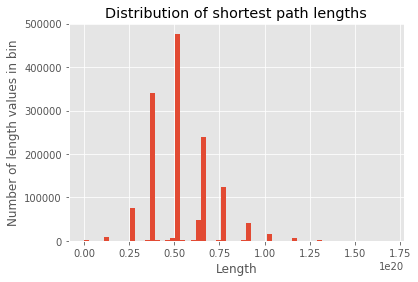

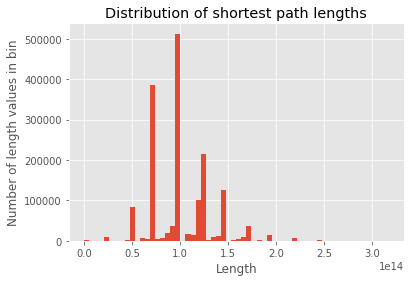

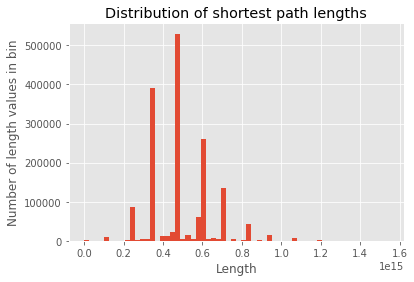

In [26]:
distributionShortestPaths(MDG_normal, weight_ = 'weight', bins = 60)
distributionShortestPaths(MDG_sensitive, weight_ = 'weight', bins = 60)
distributionShortestPaths(MDG_resistant, weight_ = 'weight', bins = 60)

In [23]:
diameterWeighted(MDG_normal, weight_ = 'weight')
diameterWeighted(MDG_sensitive, weight_ = 'weight')
diameterWeighted(MDG_resistant, weight_ = 'weight')

Weighted diameter: 1.686440837238416e+20
Weighted diameter: 316751900639809.9
Weighted diameter: 1542768097416848.8


In [24]:
avarageShortestPathLength(MDG_normal, weight_ = 'weight')
avarageShortestPathLength(MDG_sensitive, weight_ = 'weight')
avarageShortestPathLength(MDG_resistant, weight_ = 'weight')

Avarage of shortest path length: 5.414176146236123e+19
Avarage of shortest path length: 101050152758875.5
Avarage of shortest path length: 492815398861330.4
